# User Churn Prediction

In this project, we use supervised learning models to identify customers who are likely to stop using service in the future. Furthermore, we will analyze top factors that influence user retention.

CAUTION--------------------------------------------------------CAUTION

CAUTION--------------------------------------------------------CAUTION

CAUTION--------------------------------------------------------CAUTION

CAUTION--------------------------------------------------------CAUTION

CAUTION--------------------------------------------------------CAUTION


my version of this project require the imblearn package

Package can be installed with Anaconda

conda install -c glemaitre imbalanced-learn

or PIP

pip install -U imbalanced-learn

<ul>
<li>[Part 1: EDA and Preprocessing](#Part-1:-EDA-and-Preprocessing)
<li>[Part 2: Model Training and Results Evaluation](#Part-2:-Model-Training-and-Result-Evaluation)
</ul>

## EDA and Preprocessing

In [53]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

churn_df = pd.read_csv('data/churn.all')

In [54]:
print 'Number of Samples: ', churn_df.shape[0]
print 'Number of Columns: ', churn_df.shape[1]
churn_df.head()

Number of Samples:  5000
Number of Columns:  21


,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


First, I will analyze the numerical feature.

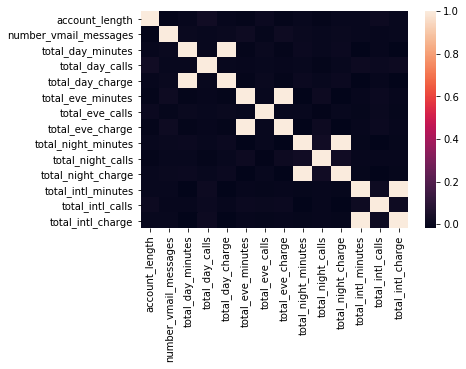

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

corr = churn_df[["account_length", "number_vmail_messages", "total_day_minutes",
                    "total_day_calls", "total_day_charge", "total_eve_minutes",
                    "total_eve_calls", "total_eve_charge", "total_night_minutes",
                    "total_night_calls","total_night_charge", "total_intl_minutes", 
                     "total_intl_calls","total_intl_charge"]].corr()

sb.heatmap(corr)

In [56]:
from scipy.stats import pearsonr

day_cor = pearsonr(churn_df['total_day_minutes'], churn_df['total_day_charge'])[0]
eve_cor = pearsonr(churn_df['total_eve_minutes'], churn_df['total_eve_charge'])[0]
night_cor = pearsonr(churn_df['total_night_minutes'], churn_df['total_night_charge'])[0]
intl_cor = pearsonr(churn_df['total_intl_minutes'], churn_df['total_intl_charge'])[0]

print 'Total day minutes vs charge: ', day_cor
print 'Total eve minutes vs charge: ', eve_cor
print 'Total night minutes vs charge: ', night_cor
print 'Total intl minutes vs charge: ', intl_cor

Total day minutes vs charge:  0.999999950983
Total eve minutes vs charge:  0.999999774863
Total night minutes vs charge:  0.999999207187
Total intl minutes vs charge:  0.999992657021


From the corr plot and the pearson coeffcients, we can observe that "minutes" columns has high correlation with "charge" columns. This make sence since the number of charge is based on the length of service used. Thus, we may drop all the "minutes" columns or all the "charge" columns since keeping both of them will not provide extra information. 

In [57]:
churn_df.drop(['total_day_charge','total_eve_charge','total_intl_charge','total_night_charge'], axis=1, inplace=True)
churn_df.head()

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,number_customer_service_calls,churned
0,KS,128,415,382-4657,no,yes,25,265.1,110,197.4,99,244.7,91,10.0,3,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,195.5,103,254.4,103,13.7,3,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,121.2,110,162.6,104,12.2,5,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,61.9,88,196.9,89,6.6,7,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,148.3,122,186.9,121,10.1,3,3,False.


#### Homework 1: Can you add catogorical features, e.g. state, into your feature matrix?

Now, I will focus on the categorical features. I will first observe the "state" and the "area_code" columns. I will first convert yes/no and True/False into 1/0.

In [58]:
churn_df['voice_mail_plan'] = churn_df['voice_mail_plan'].map(lambda x: x.strip())
churn_df['intl_plan'] = churn_df['intl_plan'].map(lambda x: x.strip())
churn_df['churned'] = churn_df['churned'].map(lambda x: x.strip())

churn_df['churned'].replace(to_replace='True.',value=1,inplace=True)
churn_df['churned'].replace(to_replace='False.',value=0,inplace=True)
churn_df['voice_mail_plan'].replace(to_replace='no',value=0,inplace=True)
churn_df['voice_mail_plan'].replace(to_replace='yes',value=1,inplace=True)
churn_df['intl_plan'].replace(to_replace='no',value=0,inplace=True)
churn_df['intl_plan'].replace(to_replace='yes',value=1,inplace=True)

In [59]:
print churn_df['area_code'].value_counts()
print churn_df['state'].value_counts()

415    2495
408    1259
510    1246
Name: area_code, dtype: int64
WV    158
MN    125
AL    124
ID    119
VA    118
OH    116
TX    116
WY    115
NY    114
OR    114
NJ    112
UT    112
WI    106
ME    103
MA    103
MI    103
MD    102
VT    101
KY     99
KS     99
CT     99
MT     99
MS     99
RI     99
WA     98
IN     98
CO     96
NH     95
DE     94
MO     93
AR     92
NM     91
SC     91
NC     91
FL     90
NV     90
OK     90
AZ     89
TN     89
IL     88
DC     88
NE     88
ND     88
HI     86
SD     85
GA     83
LA     82
PA     77
AK     72
IA     69
CA     52
Name: state, dtype: int64


CONFUSION: There are only three distinct area codes in this dataset which are 415, 408, and 510. Based on my google result, 415 is corresponding to San Francisco, California. 408 is corresponding to San Jose. 510 is corresponding to Oakland area. All of these area are in CA. So why there are 51 states contain in the dataset? Due to this confusion, I will drop the area_code column, and trust the state column.

In [60]:
churn_df.drop(['area_code'],axis=1,inplace=True)
churn_df.head()

,state,account_length,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,number_customer_service_calls,churned
0,KS,128,382-4657,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0
1,OH,107,371-7191,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0
2,NJ,137,358-1921,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0
3,OH,84,375-9999,1,0,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0
4,OK,75,330-6626,1,0,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0


Now, let's look at the state column. As observed before, the state column contain 51 distinct states, and all samples are nearly uniformly distributed in these states. One way to embed the state column could be one hot encoding. However, this approach would result 50 more features, and there is a chance of overfitting. I will embed state feature as probability of the user churned in the state. There are two benefit of this embedding. First, I'm not increasing the dimension of the dataset. Second, it makes sense intuitively. If many users in a state churned the service, there is a greater chance for other user to churned the service in the same state.

In [61]:
distinct_state = churn_df['state'].value_counts()
state_map = {}
for each_state in list(distinct_state.index):
    num_of_true = churn_df[(churn_df['state']==each_state) & (churn_df['churned']==1)].shape[0]
    num_of_false = churn_df[(churn_df['state']==each_state) & (churn_df['churned']==0)].shape[0]
    state_map[each_state] = num_of_true/float(num_of_true+num_of_false)
    
for state_name, value in state_map.iteritems():
    churn_df['state'].replace(to_replace=state_name, value=value,inplace=True)
churn_df.head()

,state,account_length,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,number_customer_service_calls,churned
0,0.181818,128,382-4657,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0
1,0.129310,107,371-7191,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0
2,0.250000,137,358-1921,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0
3,0.129310,84,375-9999,1,0,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0
4,0.177778,75,330-6626,1,0,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0


I will drop the "phone_number" column, since I assume that the phone number was randomly assigned to each user.

In [62]:
churn_df.drop(['phone_number'], axis=1, inplace=True)
churn_df.head()

,state,account_length,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,number_customer_service_calls,churned
0,0.181818,128,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0
1,0.129310,107,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0
2,0.250000,137,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0
3,0.129310,84,1,0,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0
4,0.177778,75,1,0,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0


Let's look at the remaining two features which are 'intl_plan' and 'voice_mail_plan'

In [63]:
print 'Correlation between voice_mail_plan and chruned is :',pearsonr(churn_df['voice_mail_plan'], churn_df['churned'])[0]
print 'Correlation between intl_plan and chruned is :',pearsonr(churn_df['intl_plan'], churn_df['churned'])[0]

Correlation between voice_mail_plan and chruned is : -0.110698256336
Correlation between intl_plan and chruned is : 0.259122645464


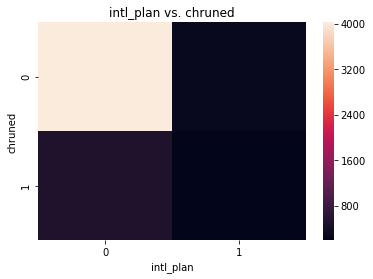

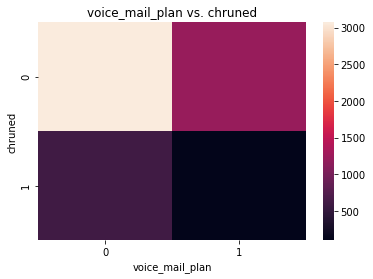

In [64]:
from sklearn.metrics import confusion_matrix
con_matrix_intl = confusion_matrix(churn_df['churned'],churn_df['intl_plan'])
ax1 = plt.axes()
sb.heatmap(con_matrix_intl, ax = ax1)
ax1.set_title('intl_plan vs. chruned')
ax1.set_xlabel('intl_plan')
ax1.set_ylabel('chruned')
plt.show()
con_matrix_voice = confusion_matrix(churn_df['churned'],churn_df['voice_mail_plan'])
ax2 = plt.axes()
sb.heatmap(con_matrix_voice, ax = ax2)
ax2.set_title('voice_mail_plan vs. chruned')
ax2.set_xlabel('voice_mail_plan')
ax2.set_ylabel('chruned')
plt.show()

Based on the Pearson Coefficient and the confusion matrix plot, both of these features have low correlation with the 'churned' column. I will keep these two features as 1/0 embedding for my classifier.

Now I finished my feature exploration.

Is there any missing value in the dataset?

In [65]:
print "Number of sample before dropna: ",churn_df.shape[0]
churn_df.dropna(inplace = True)
print "Number of sample after dropna: ",churn_df.shape[0]

Number of sample before dropna:  5000
Number of sample after dropna:  5000


There is no row with missing value. Let's check if the dataset is balanced.

In [66]:
churn_df['churned'].value_counts()

0    4293
1     707
Name: churned, dtype: int64

I will balance the dataset using over-sampling, since this is a small dataset. One way to do the over-sampling is to put copys of the sample from the minority class into the dataset. This approach could cause overfitting. I will use SMOTE algorithm to perform the over-sampling on the training samples. SMOTE algorithm will generate samples based on KNN, and the sample generated will be more generalize. Moreover, it is important to use SMOTE only for training samples, not for cross validation samples. The synthetic samples should never be used to validate the model.

In [67]:
print 'Number of samples :',churn_df.shape[0]
print 'Number of features :',churn_df.shape[1]

Number of samples : 5000
Number of features : 15


# Part 2: Model Training and Result Evaluation

In [68]:
y = np.asarray(churn_df['churned'])
X = np.asarray(churn_df.drop(['churned'],axis=1))

In [69]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

print "Feature space holds %d observations and %d features" % X.shape
print "Unique target labels:", np.unique(y)

Feature space holds 5000 observations and 14 features
Unique target labels: [0 1]


In [70]:
from sklearn.cross_validation import KFold
from imblearn.over_sampling import SMOTE

#This program does 5-fold. It saves the result at each time as different parts of y_pred. 
#In the end, it returns the y_pred as the result of all the five 5-fold.
def run_cv(X,y,clf_class,enable_SMOTE=False,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
    clf = clf_class(**kwargs)
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        
        if enable_SMOTE:
            #Apply SMOTE to over-sample the training set in order to have a balanced training set
            sm=SMOTE(random_state=42)
            X_res, y_res = sm.fit_sample(X_train, y_train)

            #The SMOTE function in imblearn API only allows numerical input, but I embeded three
            #categorical features into the dataset which are 'state', 'intl_plan', and 'voice_mail_plan'
            #The 'state' feature was converted into a probability, so it is a numerical now.
            #the 'intl_plan' and the 'voice_mail_plan' should be rounded after SMOTE
            X_res[:,1] = np.round(X_res[:,1]) #round the 'intl_plan'
            X_res[:,2] = np.round(X_res[:,2]) #round the 'voice_mail_plan'
            X_train, y_train = X_res, y_res
            
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression

def accuracy(y_true,y_pred):
    return np.mean(y_true == y_pred) # NumPy interpretes True and False as 1. and 0.

LR_CV_result_SMOTE_on = run_cv(X,y,LogisticRegression,enable_SMOTE=True)
RF_CV_result_SMOTE_on = run_cv(X,y,RandomForestClassifier,enable_SMOTE=True)
KNN_CV_result_SMOTE_on = run_cv(X,y,KNeighborsClassifier,enable_SMOTE=True) #Default: n_neighbors=5

print "Result with SMOTE enable"
print "Logistic Regression (L2 is default): " + str(accuracy(y, LR_CV_result_SMOTE_on))
print "Random forest: " + str(accuracy(y, RF_CV_result_SMOTE_on))
print "K-nearest-neighbors: " + str(accuracy(y, KNN_CV_result_SMOTE_on))

Result with SMOTE enable
Logistic Regression (L2 is default): 0.8068
Random forest: 0.9306
K-nearest-neighbors: 0.8136


In [72]:
LR_CV_result = run_cv(X,y,LogisticRegression)
RF_CV_result = run_cv(X,y,RandomForestClassifier)
KNN_CV_result = run_cv(X,y,KNeighborsClassifier) #Default: n_neighbors=5

print "Result with SMOTE disable"
print "Logistic Regression (L2 is default): " + str(accuracy(y, LR_CV_result))
print "Random forest: " + str(accuracy(y, RF_CV_result))
print "K-nearest-neighbors: " + str(accuracy(y, KNN_CV_result))

Result with SMOTE disable
Logistic Regression (L2 is default): 0.8674
Random forest: 0.9348
K-nearest-neighbors: 0.8922


The performance is getting worse when the SMOTE is enabled. However, I cannot conclude that over-sampling the training set is a bad approach at this point. First, all three model was using default hyper-pamater. I will fine-tune the hyper-parameter to further evalute the models and over-sampling approach. Second, since the dataset is unbalance, the performance should be evaluated with matrices other than accuracy.

#### Homework 2: Can you do prediction with SVM model?

First, let's apply Linear SVM. Then, I will test performance using kernal trick.

In [73]:
from sklearn.svm import LinearSVC


SVC_CV_result_SMOTE_on = run_cv(X,y,LinearSVC,enable_SMOTE=True)
print "Result with SMOTE enable : " + str(accuracy(y, SVC_CV_result_SMOTE_on))
SVC_CV_result = run_cv(X,y,LinearSVC)
print "Result with SMOTE disable : " + str(accuracy(y, SVC_CV_result))

Result with SMOTE enable : 0.8014
Result with SMOTE disable : 0.869


In [74]:
#Using SVM with rbf kernal
from sklearn.svm import SVC

SVC_kernal_result_SMOTE_on = run_cv(X,y,SVC,enable_SMOTE = True)
print "Result with SMOTE enable : " + str(accuracy(y, SVC_kernal_result_SMOTE_on))
SVC_kernal_result = run_cv(X,y,SVC,enable_SMOTE = False)
print "Result with SMOTE disable : " + str(accuracy(y, SVC_kernal_result))


Result with SMOTE enable : 0.914
Result with SMOTE disable : 0.9216


### Use Grid Search to Find Optimal Parameters

First, let's select few classifier from all the classifier we used before.

In [75]:
print "Result with SMOTE enable"
print "Logistic Regression (L2 is default): " + str(accuracy(y, LR_CV_result_SMOTE_on))
print "Random forest: " + str(accuracy(y, RF_CV_result_SMOTE_on))
print "K-nearest-neighbors: " + str(accuracy(y, KNN_CV_result_SMOTE_on))
print "Linear SVM: " + str(accuracy(y, SVC_CV_result_SMOTE_on))
print "SVM with rbf kernal: " + str(accuracy(y, SVC_kernal_result_SMOTE_on))

Result with SMOTE enable
Logistic Regression (L2 is default): 0.8068
Random forest: 0.9306
K-nearest-neighbors: 0.8136
Linear SVM: 0.8014
SVM with rbf kernal: 0.914


In [76]:
print "Result with SMOTE disable"
print "Logistic Regression (L2 is default): " + str(accuracy(y, LR_CV_result))
print "Random forest: " + str(accuracy(y, RF_CV_result))
print "K-nearest-neighbors: " + str(accuracy(y, KNN_CV_result))
print "Linear SVM : " + str(accuracy(y, SVC_CV_result))
print "SVM with rbf kernal : " + str(accuracy(y, SVC_kernal_result))

Result with SMOTE disable
Logistic Regression (L2 is default): 0.8674
Random forest: 0.9348
K-nearest-neighbors: 0.8922
Linear SVM : 0.869
SVM with rbf kernal : 0.9216


I will use grid search to fine-tune the hyper-parameter for Random forest, K-nearest-neighbors, and SVM with rbf kernal, since they have the best performance from last section.

In [77]:
def print_grid_search_metrics(gs):
    print "Best score: %0.3f" % gs.best_score_
    print "Best parameters set:"
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [78]:
#Random Forest
from sklearn.grid_search import GridSearchCV
parameters = {
    'n_estimators':(5,10,20,30,50,100,200,500), 
    'max_depth':(1,2,5,8,10,12),
    'max_features':(0.2,0.3,0.5,0.8)
}
Random_Forest_Grid_LR = GridSearchCV(RandomForestClassifier(n_jobs=-1),parameters, cv=5, verbose=1,n_jobs=-1, refit=False)
Random_Forest_Grid_LR.fit(X, y)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:  1.5min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': (5, 10, 20, 30, 50, 100, 200, 500), 'max_features': (0.2, 0.3, 0.5, 0.8), 'max_depth': (1, 2, 5, 8, 10, 12)},
       pre_dispatch='2*n_jobs', refit=False, scoring=None, verbose=1)

In [79]:
print_grid_search_metrics(Random_Forest_Grid_LR)

Best score: 0.956
Best parameters set:
	max_depth: 12
	max_features: 0.5
	n_estimators: 100


The following are the best hyper-parameter from grid search for Random Forest Classifier
Best score: 0.956
Best parameters set:
	max_depth: 12
	max_features: 0.5
	n_estimators: 30